# 모듈 로드

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Input, Lambda, Dropout
from keras.optimizers import Adam
from keras import backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
import math 

In [ ]:
import cv2
import os
import numpy as np
from sklearn.utils import shuffle
from google.colab.patches import cv2_imshow

# 이미지 로드 및 전처리

In [ ]:
from typing import Tuple

def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    """ Crops the center of an image
        Parameters
        ----------
        img : np.ndarray (H x W)
            The image to be cropped
        size: tuple (H x W)
            The desired size
        Returns
        -------
        np.ndarray
            The cRecentropped image
        """
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0]-10, start_x+6:start_x + size[1]-11]
    cropped = cv2.resize(cropped, (105,105))
    return cropped

In [ ]:
def input_img(path):
  img_width, img_height = 105, 105
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # 그레이스케일
  img = cv2.resize(img,(img_width,img_height)) # 이미지 리사이즈
  img = crop_center(img, img.shape) # 
  ret, img = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY) # 이미지 이진화
  return ret, img
ret, dst = input_img('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/Forged/NFI-00101014.png')

In [ ]:
def pre_processing(path):
  img_width = 105
  img_height = 105
  imgs_arr = []
  temp = []
  for filename in sorted(os.listdir(path)):
    if filename.endswith(".png") or filename.endswith(".PNG"): # 확장자맞는 파일 로드
      # if len(imgs_arr) > 100:
      #   break
      fullpath = os.path.join(path,filename)
      img = cv2.imread(fullpath, cv2.IMREAD_GRAYSCALE) # 그레이스케일
      img = cv2.resize(img,(img_width,img_height)) # 이미지 리사이즈
      img = crop_center(img, img.shape)
      ret, dst = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY) # 이미지 이진화
      temp.append(dst)
      print(len(imgs_arr), filename)
      cv2_imshow(dst)
      imgs_arr.append(np.array(dst))
    else:
      print("pass")
  return temp, np.array(imgs_arr)

In [ ]:
imgs1, arr1 = pre_processing('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_org')
imgs2, arr2 = pre_processing('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_forg')

In [ ]:
arr1[0].shape

(105, 105)

# 모델 정의

In [ ]:
def siam(input_shape):

  left_input = Input(input_shape)
  right_input = Input(input_shape)
  
  model = Sequential()

  model.add(Conv2D(64, (10,10), input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(128, (7,7),))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(128, (4,4)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(256, (4,4)))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(4096, activation='sigmoid'))
  #model.add(Dropout(0.2)) 

  encoder_l = model(left_input)
  encoder_r = model(right_input)

  L1_layer = Lambda(lambda x:K.abs(x[0] - x[1]))
  distance = L1_layer([encoder_l,encoder_r])

  prediction = Dense(1, activation='sigmoid')(distance)

  siam_net = Model(inputs=[left_input,right_input],outputs=prediction)

  return siam_net

In [ ]:
model = siam((105, 105, 1))
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         10636096    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[0][0]      

## 모델구조 시각화

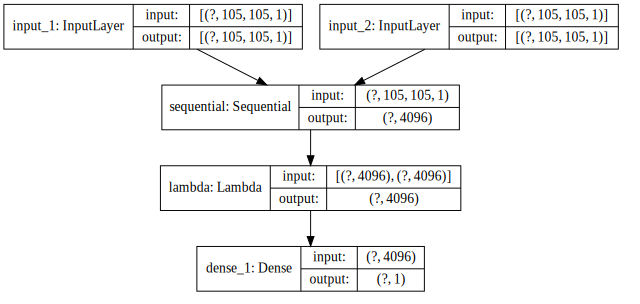

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi = 70).create(prog='dot', format='svg'))

# 모델 컴파일

In [ ]:
def accuracy(y_true, y_pred):
  print(y_true, y_pred)
  return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
optimizer = Adam(lr = 0.00001)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

# 알고리즘

## 사용된 알고리즘
* 히스토그램
* 와셔스테인 거리
* MSE
* SSIM(가장 잘 쓰임)
* PIXEL
* SIFT
* Image HASH

In [ ]:
from skimage.measure import compare_ssim
from skimage.transform import resize
from scipy.stats import wasserstein_distance
import numpy as np
import cv2

# specify resized image sizes
height = 105
width = 105

def get_img(path, norm_size=True, norm_exposure=False):
  '''
  Prepare an image for image processing tasks
  '''
  # flatten returns a 2d grayscale array
  img = imread(path, flatten=True).astype(int)
  # resizing returns float vals 0:255; convert to ints for downstream tasks
  if norm_size:
    img = resize(img, (height, width), anti_aliasing=True, preserve_range=True)
  if norm_exposure:
    img = normalize_exposure(img)
  return img


def get_histogram(img):
  '''
  Get the histogram of an image. For an 8-bit, grayscale image, the
  histogram will be a 256 unit vector in which the nth value indicates
  the percent of the pixels in the image with the given darkness level.
  The histogram's values sum to 1.
  '''
  h, w = img.shape
  hist = [0.0] * 256
  for i in range(h):
    for j in range(w):
      hist[img[i, j]] += 1
  return np.array(hist) / (h * w)


def normalize_exposure(img):
  '''
  Normalize the exposure of an image.
  '''
  img = img.astype(int)
  hist = get_histogram(img)
  # get the sum of vals accumulated by each position in hist
  cdf = np.array([sum(hist[:i+1]) for i in range(len(hist))])
  # determine the normalization values for each unit of the cdf
  sk = np.uint8(255 * cdf)
  # normalize each position in the output image
  height, width = img.shape
  normalized = np.zeros_like(img)
  for i in range(0, height):
    for j in range(0, width):
      normalized[i, j] = sk[img[i, j]]
  return normalized.astype(int)


def earth_movers_distance(a, b):
  '''
  Measure the Earth Mover's distance between two images
  @args:
    {str} path_a: the path to an image file 
    {str} path_b: the path to an image file
  @returns:
    TODO
  '''
  hist_a = get_histogram(a)
  hist_b = get_histogram(b)
  return wasserstein_distance(hist_a, hist_b)


def structural_sim(a, b):
  '''
  Measure the structural similarity between two images
  @args:
    {str} path_a: the path to an image file
    {str} path_b: the path to an image file
  @returns:
    {float} a float {-1:1} that measures structural similarity
      between the input images
  # '''
  sim, diff = compare_ssim(a, b, full=True, multichannel=True)
  return sim


def pixel_sim(a, b):
  '''
  Measure the pixel-level similarity between two images
  @args:
    {str} path_a: the path to an image file
    {str} path_b: the path to an image file
  @returns:
    {float} a float {-1:1} that measures structural similarity
      between the input images
  '''
  return np.sum(np.absolute(a - b)) / (height*width) / 255


def sift_sim(a, b):
  '''
  Use SIFT features to measure image similarity
  @args:
    {str} path_a: the path to an image file
    {str} path_b: the path to an image file
  @returns:
    TODO
  '''
  # initialize the sift feature detector
  orb = cv2.ORB_create()


  # find the keypoints and descriptors with SIFT
  kp_a, desc_a = orb.detectAndCompute(a, None)
  kp_b, desc_b = orb.detectAndCompute(b, None)

  # initialize the bruteforce matcher
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

  # match.distance is a float between {0:100} - lower means more similar
  matches = bf.match(desc_a, desc_b)
  similar_regions = [i for i in matches if i.distance < 70]
  if len(matches) == 0:
    return 0
  return len(similar_regions) / len(matches)

### True / True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


structural_sim 0.6734649826236773 
pixel_sim 26.64753581432573 
sift_sim 0.9402985074626866


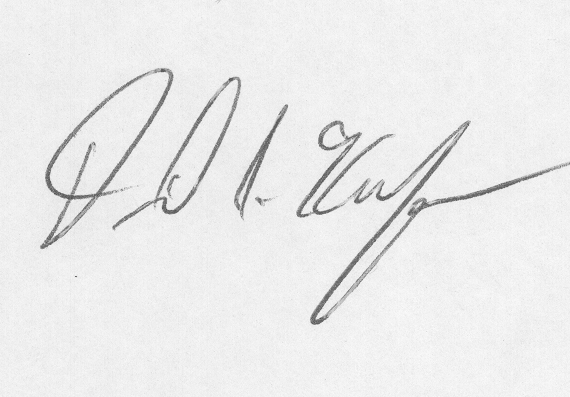

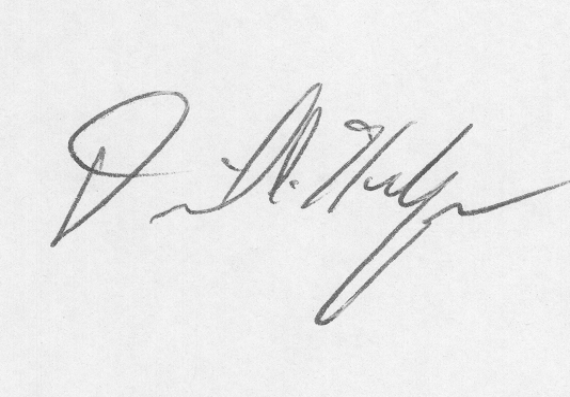

structural_sim 0.6869380120960619 
pixel_sim 54.74046258503402 
sift_sim 0.9292035398230089


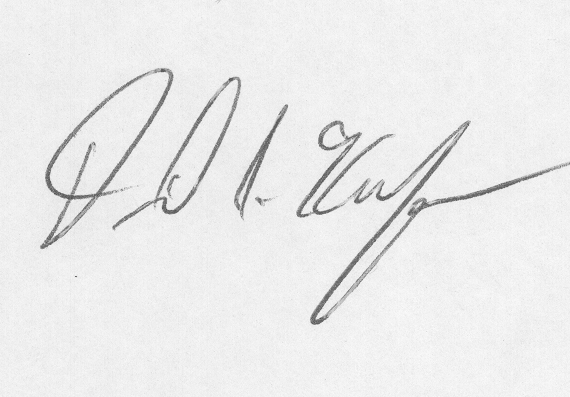

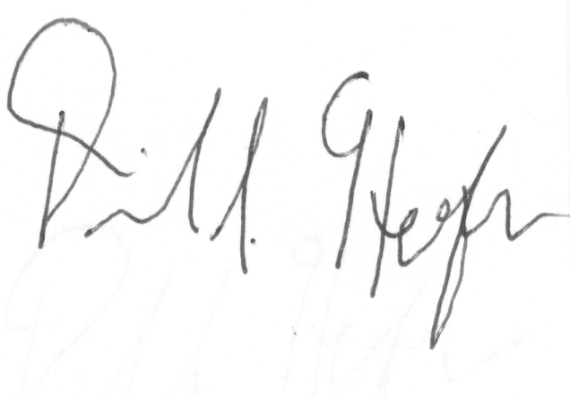

In [ ]:
# 전처리 X
img_a = cv2.imread('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_org/original_10_4.png')
img_b = cv2.imread('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_org/original_10_1.png')
img_c = cv2.imread('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_forg/forgeries_10_4.png')
x, y, c = img_a.shape
img_b = cv2.resize(img_b,(y,x))
img_c = cv2.resize(img_c,(y,x))
img_a = np.array(img_a)
img_b = np.array(img_b)
img_c = np.array(img_c)

# get the similarity values
Structural_sim = structural_sim(img_a, img_b)
Pixel_sim = pixel_sim(img_a, img_b)
Sift_sim = sift_sim(img_a, img_b)
print("structural_sim", Structural_sim, "\npixel_sim", Pixel_sim, "\nsift_sim", Sift_sim)
cv2_imshow(img_a)
cv2_imshow(img_b)

Structural_sim = structural_sim(img_a, img_c)
Pixel_sim = pixel_sim(img_a, img_c)
Sift_sim = sift_sim(img_a, img_c)
print("structural_sim", Structural_sim, "\npixel_sim", Pixel_sim, "\nsift_sim", Sift_sim)
cv2_imshow(img_a)
cv2_imshow(img_c)

structural_sim 1.0 
pixel_sim 0.0 
sift_sim 1.0 
emd 0.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


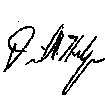

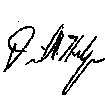

structural_sim 0.634706914368303 
pixel_sim 0.07530407718643013 
sift_sim 0.25 
emd 2.8344671201813013e-06


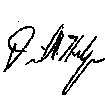

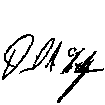

structural_sim 0.6285720436262395 
pixel_sim 0.07461437908496732 
sift_sim 0.4 
emd 7.440476190476224e-05


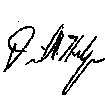

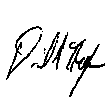

structural_sim 0.6519654855928176 
pixel_sim 0.07159877284247032 
sift_sim 0.7391304347826086 
emd 5.314625850340142e-05


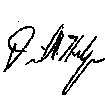

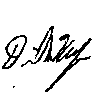

In [ ]:
# 전처리 O
img_a = arr1[0]
img_b = arr1[0]
# get the similarity values
Structural_sim = structural_sim(img_a, img_b)
Pixel_sim = pixel_sim(img_a, img_b)
Sift_sim = sift_sim(img_a, img_b)
Emd = earth_movers_distance(img_a, img_b)
print("structural_sim", Structural_sim, "\npixel_sim", Pixel_sim, "\nsift_sim", Sift_sim, "\nemd", Emd)
cv2_imshow(img_a)
cv2_imshow(img_b)

img_a = arr1[0]
img_b = arr1[1]
# get the similarity values
Structural_sim = structural_sim(img_a, img_b)
Pixel_sim = pixel_sim(img_a, img_b)
Sift_sim = sift_sim(img_a, img_b)
Emd = earth_movers_distance(img_a, img_b)
print("structural_sim", Structural_sim, "\npixel_sim", Pixel_sim, "\nsift_sim", Sift_sim, "\nemd", Emd)
cv2_imshow(img_a)
cv2_imshow(img_b)

img_a = arr1[0]
img_b = arr1[2]
# get the similarity values
Structural_sim = structural_sim(img_a, img_b)
Pixel_sim = pixel_sim(img_a, img_b)
Sift_sim = sift_sim(img_a, img_b)
Emd = earth_movers_distance(img_a, img_b)
print("structural_sim", Structural_sim, "\npixel_sim", Pixel_sim, "\nsift_sim", Sift_sim, "\nemd", Emd)
cv2_imshow(img_a)
cv2_imshow(img_b)

img_a = arr1[0]
img_b = arr1[3]
# get the similarity values
Structural_sim = structural_sim(img_a, img_b)
Pixel_sim = pixel_sim(img_a, img_b)
Sift_sim = sift_sim(img_a, img_b)
Emd = earth_movers_distance(img_a, img_b)
print("structural_sim", Structural_sim, "\npixel_sim", Pixel_sim, "\nsift_sim", Sift_sim, "\nemd", Emd)
cv2_imshow(img_a)
cv2_imshow(img_b)

### False / False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


structural_sim 1.0 
pixel_sim 0.0 
sift_sim 1.0 
emd 0.0


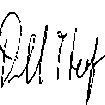

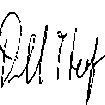

structural_sim 0.5909699780714639 
pixel_sim 0.06947169979102752 
sift_sim 0.1111111111111111 
emd 0.00016935941043083922


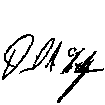

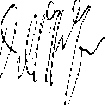

structural_sim 0.6446349412313782 
pixel_sim 0.06317229113867769 
sift_sim 0.14285714285714285 
emd 0.00013676303854875266


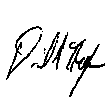

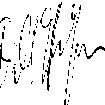

structural_sim 0.6040535073163218 
pixel_sim 0.09194326619536704 
sift_sim 0.0 
emd 5.172902494331074e-05


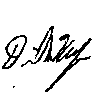

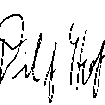

In [ ]:
img_a = arr2[11]
img_b = arr2[11]
# get the similarity values
Structural_sim = structural_sim(img_a, img_b)
Pixel_sim = pixel_sim(img_a, img_b)
Sift_sim = sift_sim(img_a, img_b)
Emd = earth_movers_distance(img_a, img_b)
print("structural_sim", Structural_sim, "\npixel_sim", Pixel_sim, "\nsift_sim", Sift_sim, "\nemd", Emd)
cv2_imshow(img_a)
cv2_imshow(img_b)

img_a = arr1[1]
img_b = arr2[1]
# get the similarity values
Structural_sim = structural_sim(img_a, img_b)
Pixel_sim = pixel_sim(img_a, img_b)
Sift_sim = sift_sim(img_a, img_b)
Emd = earth_movers_distance(img_a, img_b)
print("structural_sim", Structural_sim, "\npixel_sim", Pixel_sim, "\nsift_sim", Sift_sim, "\nemd", Emd)
cv2_imshow(img_a)
cv2_imshow(img_b)

img_a = arr1[2]
img_b = arr2[2]
# get the similarity values
Structural_sim = structural_sim(img_a, img_b)
Pixel_sim = pixel_sim(img_a, img_b)
Sift_sim = sift_sim(img_a, img_b)
Emd = earth_movers_distance(img_a, img_b)
print("structural_sim", Structural_sim, "\npixel_sim", Pixel_sim, "\nsift_sim", Sift_sim, "\nemd", Emd)
cv2_imshow(img_a)
cv2_imshow(img_b)

img_a = arr1[3]
img_b = arr2[3]
# get the similarity values
Structural_sim = structural_sim(img_a, img_b)
Pixel_sim = pixel_sim(img_a, img_b)
Sift_sim = sift_sim(img_a, img_b)
Emd = earth_movers_distance(img_a, img_b)
print("structural_sim", Structural_sim, "\npixel_sim", Pixel_sim, "\nsift_sim", Sift_sim, "\nemd", Emd)
cv2_imshow(img_a)
cv2_imshow(img_b)

이미지 해쉬
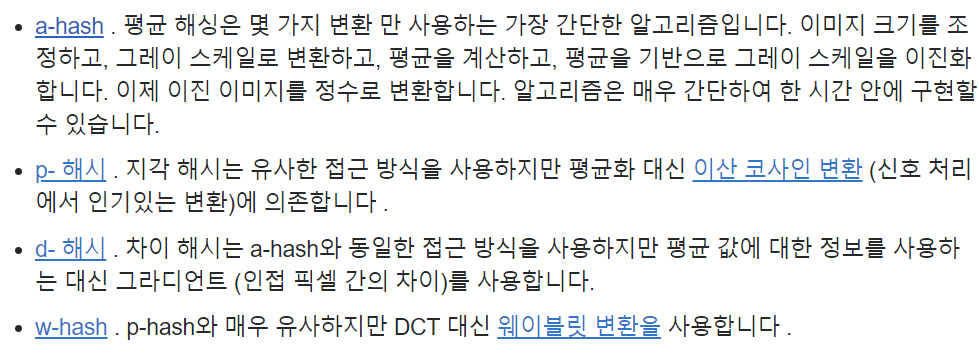

In [ ]:
# https://pypi.org/project/ImageHash/
!pip install imagehash

     |████████████████████████████████| 296kB 10.8MB/s 


In [ ]:
from PIL import Image
import imagehash

In [ ]:
hash =       imagehash.average_hash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_org/original_10_1.png'))
other_hash = imagehash.average_hash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_org/original_10_2.png'))
false_hash = imagehash.average_hash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_forg/forgeries_10_4.png'))
print(hash)
print(other_hash)
print(false_hash)
print("true ",hash - other_hash)
print("false",hash - false_hash)

ffff830109f3f7ff
ffdf8180b3f7ffff
3f7f230108f9fdff
true  11
false 10


In [ ]:
hash =       imagehash.phash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_org/original_10_1.png'))
other_hash = imagehash.phash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_org/original_10_9.png'))
false_hash = imagehash.phash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_forg/forgeries_10_4.png'))
print(hash)
print(other_hash)
print(false_hash)
print("true ",hash - other_hash)
print("false",hash - false_hash)

af3b90c94b27a49a
ad93d24c69b2917a
a90496cb5bb7a549
true  22
false 20


In [ ]:
hash =       imagehash.dhash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_org/original_10_1.png'))
other_hash = imagehash.dhash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_org/original_10_2.png'))
false_hash = imagehash.dhash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_forg/forgeries_10_4.png'))
print(hash)
print(other_hash)
print(false_hash)
print("true ",hash - other_hash)
print("false",hash - false_hash)

d92c6f4b53d625aa
90346f6f47a428d0
60e6d65593530b83
true  21
false 30


In [ ]:
hash =       imagehash.whash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_org/original_10_1.png'))
other_hash = imagehash.whash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_org/original_10_4.png'))
false_hash = imagehash.whash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_forg/forgeries_10_4.png'))
print(hash)
print(other_hash)
print(false_hash)
print("true ",hash - other_hash)
print("false",hash - false_hash)

7f17010000b3f7ff
bf0f01000173f7df
3f33030100e1fdff
true  8
false 10


# Train Data prepare

In [ ]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# np.set_printoptions(threshold=np.inf, linewidth=np.inf)

In [ ]:
# True데이터 행 당기기
X = []
for i in range(len(arr1)-1):
  if i%23 == 0:
    continue
  X.append(arr1[i+1])
len(arr1)
print("\n")
len(X)

1261

In [ ]:
# False 데이터 행 당기기
X2 = []
for i in range(len(arr2)-1):
  if i%23 == 0:
    continue
  X2.append(arr2[i+1])
len(arr2)
print("\n")
len(X2)

1261

In [ ]:
# 데이터 0~23 같은데이터 == 첫번째 값으로 초기화
for i in range(len(X)):
  for j in range(23):
    X[i] = X[i//23]

In [ ]:
# 예측에 사용될 y값 half T / half F
i = [ 1 for _ in range(len(X)//2)]
j = [ 0 for _ in range(len(X) - len(X)//2 )]
y = np.concatenate((i,j), axis = 0)
len(y)

1261

In [ ]:
# X2 => False list set the half for true data
tmp = arr2
tmp = np.array(tmp)
# half true / half false
pivot = len(X2[len(X2)//2:])
for i in range(pivot):
  X2[i] = X[i]

In [ ]:
# Train Test Validation Split
from sklearn.model_selection import train_test_split
X, X2 = np.array(X), np.array(X2)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size = 0.3, random_state=0)
X_train = [X_train1, X_train2]
X_test = [X_test1, X_test2]

# 학습

In [ ]:
print("\n")
early_stopping = EarlyStopping()
history = model.fit(X_train, 
                    y_train1, 
                    epochs=100,
                    verbose=1, 
                    batch_size=32,
                    validation_data = (X_test, y_test1),
                    shuffle=True)



Epoch 1/100
28/28 [==============================] - 2s 71ms/step - loss: 0.3944 - val_loss: 0.3301
Epoch 2/100
28/28 [==============================] - 2s 54ms/step - loss: 0.3547 - val_loss: 0.3292
Epoch 3/100
28/28 [==============================] - 1s 53ms/step - loss: 0.3544 - val_loss: 0.3291
Epoch 4/100
28/28 [==============================] - 2s 54ms/step - loss: 0.3543 - val_loss: 0.3290
Epoch 5/100
28/28 [==============================] - 1s 53ms/step - loss: 0.3542 - val_loss: 0.3289
Epoch 6/100
28/28 [==============================] - 2s 54ms/step - loss: 0.3541 - val_loss: 0.3288
Epoch 7/100
28/28 [==============================] - 2s 54ms/step - loss: 0.3540 - val_loss: 0.3288
Epoch 8/100
28/28 [==============================] - 2s 54ms/step - loss: 0.3539 - val_loss: 0.3287
Epoch 9/100
28/28 [==============================] - 2s 54ms/step - loss: 0.3539 - val_loss: 0.3286
Epoch 10/100
28/28 [==============================] - 2s 54ms/step - loss: 0.3538 - val_loss: 0.32

In [ ]:
# print(history.history['loss'])
# print(history.history['acc'])
# print(history.history['val_loss'])
# print(history.history['val_acc'])

In [ ]:
model.save('SigNet.h5')

# 테스트

In [ ]:
a = arr1[10].reshape(1,105,105,1)
b = arr2[10].reshape(1,105,105,1)
model.predict([a,b]).tolist()[0][0]

0.0007787213544361293

In [ ]:
result = []
for i in range(len(X_test1)):
  a = X_test1[i].reshape(1,105,105,1)
  b = X_test2[i].reshape(1,105,105,1)
  tmp = model.predict([a,b]).tolist()[0][0]
  result.append(round(tmp))
count = 0
for i in range(len(result)):
  if result[i] == y_test1[i]:
    count += 1
print("acc : ", (count/len(y_test1))*100)

acc :  100.0


# 해쉬 VS 딥러닝

In [ ]:
# 해쉬
hash =       imagehash.dhash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/genuine/NFI-00101001.png'))
other_hash = imagehash.dhash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/genuine/NFI-00105001.png'))
false_hash = imagehash.dhash(Image.open('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/조작3.jpg'))
print(hash)
print(other_hash)
print(false_hash)
print("true ",hash - other_hash)
print("false",hash - false_hash)

20015c550b3ff802
20927c4f5b7e0002
08015c554f7ffc01
true  17
false 8


In [ ]:
# 딥러닝
aa, a = input_img('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/genuine/NFI-00101001.png')
bb, b = input_img('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/Forged/NFI-00303001.png')
#bb, b = input_img('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/genuine/NFI-00105001.png')
a = a.reshape(1,105,105,1)
b = b.reshape(1,105,105,1)
model.predict([a,b]).tolist()[0][0]

0.002761125797405839

# 테스트코드

In [ ]:
from tensorflow import keras 
SigNet = keras.models.load_model('/content/SigNet.h5')

In [ ]:
# 딥러닝
aa, a = input_img('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/genuine/NFI-00105001.png')
bb, b = input_img('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/Forged/NFI-00303001.png')
#bb, b = input_img('/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/genuine/NFI-00105001.png')
a = a.reshape(1,105,105,1)
b = b.reshape(1,105,105,1)
SigNet.predict([a,b]).tolist()[0][0]

0.0018873169319704175

# 서명인식 SigNet

In [ ]:
PATH_ORG = '/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_org'
PATH_FORG = '/content/drive/MyDrive/Colab Notebooks/datasets/sample_Signature/full_forg'

In [ ]:
import os
from natsort import natsorted, ns

def get_image_list():
  org_signs = os.listdir(PATH_ORG)
  forg_signs = os.listdir(PATH_FORG)
  org_signs = [s for s in org_signs if s.endswith(".png")]
  forg_signs = [s for s in forg_signs if s.endswith(".png")]
  org_signs = natsorted(org_signs, alg=ns.IGNORECASE)
  forg_signs = natsorted(forg_signs, alg=ns.IGNORECASE)
  return org_signs, forg_signs

# data cleaning|
def check_lists(org_signs,forg_signs):
  flag = False
  for i in range(len(org_signs)):
    org_ext = org_signs[i][8:]
    forg_ext = forg_signs[i][9:]
    if org_ext != forg_ext:
      flag = True
      #print(i,org_ext,forg_ext)
  '''if(flag):
    #print("Mismatches found")
  else:
    #print("No mismatch found")
'''
def refine_lists(org_signs,forg_signs):
  refined_org_signs = []
  for i in range(len(org_signs)):
    if "_41_" in org_signs[i]:
      continue
    refined_org_signs.append(org_signs[i])
  
  refined_forg_signs = []
  for i in range(len(forg_signs)):
    if "_41_" in forg_signs[i]:
      continue
    refined_forg_signs.append(forg_signs[i])
  return refined_org_signs, refined_forg_signs

def get_clean_lists():
  org_signs, forg_signs = get_image_list()
  check_lists(org_signs,forg_signs)
  org_signs, forg_signs = refine_lists(org_signs,forg_signs)
  #print(len(org_signs),len(forg_signs))
  check_lists(org_signs,forg_signs)
  return org_signs, forg_signs

import random
import pandas as pd
import numpy as np

def get_dataframe(org_signs,forg_signs):
  no_of_ppl = len(org_signs)//24

  raw_data = {"image_1":[], "image_2":[], "label":[]}
  for i in range(no_of_ppl):
    i1_batch_1 = []
    i1_batch_2 = []
    i2_batch = []

    start = i*24
    end = (i+1)*24

    for j in range(start,end): 
      i1_batch_1.append(os.path.join(PATH_ORG,org_signs[j]))
      i1_batch_2.append(os.path.join(PATH_ORG,org_signs[j]))
      raw_data["label"].append(1)#0

    temp_rot = (i1_batch_1[-12:]+i1_batch_1[:-12])
    i1_batch_1.extend(i1_batch_2)

    for elem in temp_rot:
      i2_batch.append(elem)

    for j in range(start,end): 
      i2_batch.append(os.path.join(PATH_FORG,forg_signs[j]))
      raw_data["label"].append(0)#1

    raw_data["image_1"].extend(i1_batch_1)
    raw_data["image_2"].extend(i2_batch)
  df = pd.DataFrame(raw_data, columns = ["image_1","image_2","label"])
  df=df.reindex(np.random.permutation(df.index))
  return df

from sklearn.model_selection import train_test_split

def get_dataset(subset=None):
  org_signs,forg_signs = get_clean_lists()
  df = get_dataframe(org_signs,forg_signs)
  #print(df.shape)
  train_set, val_set = train_test_split(df,test_size=0.3,random_state=0)
  if(subset.lower()=="train"):
    dataset = train_set
  else:
    dataset = val_set
  return dataset

In [ ]:
import numpy as np
import keras
from PIL import Image
import cv2

class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, df, batch_size=32, dim=(155,220), n_channels=3, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.labels = df["label"]
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        rows = [self.df.iloc[k] for k in indexes]
        X, y = self.__data_generation(rows)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(self.df.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, rows):
        x_1 = np.empty((self.batch_size, *self.dim, self.n_channels))
        x_2 = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        for i in range(len(rows)):
            image_1 = cv2.imread(rows[i]["image_1"])
            image_1 = cv2.resize(image_1,(220,155))
            image_1 = cv2.bitwise_not(image_1)
            image_1=np.array(image_1)
            image_2 = cv2.imread(rows[i]["image_2"])
            image_2 = cv2.resize(image_2,(220,155))
            image_2 = cv2.bitwise_not(image_2)
            image_2=np.array(image_2)
            '''mean_center_1 = image_1 - np.mean(image_1, axis = None)
            mean_center_2 = image_2 - np.mean(image_2, axis = None)
            
            std_1 = np.std(image_1)
            std_2 = np.std(image_2)
            if(std_1 == 0 or std_1 == np.nan):
                std_1 = 1
            if(std_2 == 0 or std_2 == np.nan):
                std_2 = 1
            standardized_img_1 = image_1/std_1
            standardized_img_2 = image_2/std_2
            '''
            x_1[i,] = image_1/255
            x_2[i,] = image_2/255
            y[i] = rows[i]["label"]


        return [x_1, x_2], y

In [ ]:
import numpy as np
import keras
from PIL import Image
import cv2

class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, df, batch_size=32, dim=(155,220), n_channels=3, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.labels = df["label"]
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        rows = [self.df.iloc[k] for k in indexes]
        X, y = self.__data_generation(rows)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(self.df.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, rows):
        x_1 = np.empty((self.batch_size, *self.dim, self.n_channels))
        x_2 = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        for i in range(len(rows)):
            image_1 = cv2.imread(rows[i]["image_1"])
            image_1 = cv2.resize(image_1,(220,155))
            image_1 = cv2.bitwise_not(image_1)
            image_1=np.array(image_1)
            image_2 = cv2.imread(rows[i]["image_2"])
            image_2 = cv2.resize(image_2,(220,155))
            image_2 = cv2.bitwise_not(image_2)
            image_2=np.array(image_2)
            '''mean_center_1 = image_1 - np.mean(image_1, axis = None)
            mean_center_2 = image_2 - np.mean(image_2, axis = None)
            
            std_1 = np.std(image_1)
            std_2 = np.std(image_2)
            if(std_1 == 0 or std_1 == np.nan):
                std_1 = 1
            if(std_2 == 0 or std_2 == np.nan):
                std_2 = 1
            standardized_img_1 = image_1/std_1
            standardized_img_2 = image_2/std_2
            '''
            x_1[i,] = image_1/255
            x_2[i,] = image_2/255
            y[i] = rows[i]["label"]
        y = y.astype(np.float64)
        print(x_1)
        return [x_1, x_2], y

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, Input, Dropout, Flatten
from keras.models import Model

def get_base_net():
  input = Input(shape=(155,220,3))
  
  conv_1 = Conv2D(filters=96, kernel_size=(11,11))(input)
  batch_norm_1 = BatchNormalization()(conv_1)
  activation_1 = Activation('relu')(batch_norm_1)
  max_pool_1 = MaxPooling2D(pool_size=(3,3))(activation_1)
  
  conv_2 = Conv2D(filters=256, kernel_size=(5,5))(max_pool_1)
  batch_norm_2 = BatchNormalization()(conv_2)
  activation_2 = Activation('relu')(batch_norm_2)
  max_pool_2 = MaxPooling2D(pool_size=(3,3))(activation_1)
  
  dropout_1 = Dropout(rate=0.3)(max_pool_2)
  
  conv_3_a = Conv2D(filters=384, kernel_size=(3,3))(dropout_1)
  activation_3_a = Activation('relu')(conv_3_a)
  conv_3_b = Conv2D(filters=256, kernel_size=(3,3))(activation_3_a)
  activation_3_b = Activation('relu')(conv_3_b)
  max_pool_3 = MaxPooling2D(pool_size=(3,3))(activation_3_b)
  
  dropout_2 = Dropout(rate=0.3)(max_pool_3)
  
  flat_1 = Flatten()(dropout_2)
  fc_1 = Dense(units=1024,activation='relu')(flat_1)
  dropout_3 = Dropout(rate=0.5)(fc_1)
  fc_2 = Dense(units=128,activation='relu')(dropout_3)
  return Model(input,fc_2)

In [ ]:
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    #print("y_pred",y_pred)
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true)* margin_square) 
  
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
from keras.layers import Lambda

input_a = Input(shape=(155,220,3))
input_b = Input(shape=(155,220,3))

base_net = get_base_net()
processed_a = base_net(input_a)
processed_b = base_net(input_b)

distance = Lambda(euclidean_distance,output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model = Model([input_a, input_b], distance)

In [ ]:
from keras import optimizers
optimizer = optimizers.RMSprop()
model.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[accuracy])

In [ ]:
params={
    'dim': (155,220),
    'batch_size': 32,
    'n_channels': 3,
    'shuffle': False
}

#train_set = 2592*0.7 = 1814 == 1814/32 == 56
#val_set = 2592*0.3 = 777 == 777/32 == 24
ds_train = get_dataset("train")
ds_val = get_dataset("val")
train_datagen = DataGenerator(ds_train,**params)
validation_datagen = DataGenerator(ds_val,**params)
model.fit_generator(generator=train_datagen, validation_data=validation_datagen, epochs=30, steps_per_epoch=56, validation_steps=24, use_multiprocessing=True)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   [0.04705882 0.04705882 0.04705882]
   [0.03137255 0.03137255 0.03137255]
   [0.04313725 0.04313725 0.04313725]]

  [[0.07843137 0.07843137 0.07843137]
   [0.0627451  0.0627451  0.0627451 ]
   [0.0627451  0.0627451  0.0627451 ]
   ...
   [0.05490196 0.05490196 0.05490196]
   [0.03921569 0.03921569 0.03921569]
   [0.05098039 0.05098039 0.05098039]]

  ...

  [[0.07058824 0.07058824 0.07058824]
   [0.06666667 0.06666667 0.06666667]
   [0.07058824 0.07058824 0.07058824]
   ...
   [0.04705882 0.04705882 0.04705882]
   [0.05490196 0.05490196 0.05490196]
   [0.05882353 0.05882353 0.05882353]]

  [[0.08235294 0.08235294 0.08235294]
   [0.0745098  0.0745098  0.0745098 ]
   [0.07843137 0.07843137 0.07843137]
   ...
   [0.05098039 0.05098039 0.05098039]
   [0.05490196 0.05490196 0.05490196]
   [0.05098039 0.05098039 0.05098039]]

  [[0.0627451  0.0627451  0.0627451 ]
   [0.07058824 0.07058824 0.07058824]
   [0.07058824 0.07058824 0.07058824]
   ...
   [0.066

In [ ]:
'''
last step of training :
Epoch 30/30
56/56 [==============================] - 61s 1s/step - loss: 0.3110 - accuracy: 0.8142 - val_loss: 0.0254 - val_accuracy: 0.9753
<keras.callbacks.History at 0x7f4ccc806eb8>
'''
model.save("drive/My Drive/Colab Notebooks/SigNet/colab_08072019.h5")

In [ ]:
from keras.models import load_model

mod = load_model('./drive/My Drive/Colab Notebooks/SigNet/colab_08072019.h5',custom_objects={'contrastive_loss':contrastive_loss})
im_1 = cv2.imread("drive/My Drive/Colab Notebooks/SigNet/signatures/signatures/full_org/original_13_1.png")
im_2 = cv2.imread("drive/My Drive/Colab Notebooks/SigNet/signatures/signatures/full_org/original_13_13.png")  
im_1 = cv2.resize(im_1,(220,155))
im_2 = cv2.resize(im_2,(220,155))
im_1 = cv2.bitwise_not(im_1)
im_2 = cv2.bitwise_not(im_2)
im_1 = im_1/255
im_2 = im_2/255
im_1 = np.expand_dims(im_1,axis=0)
im_2 = np.expand_dims(im_2,axis=0)
y_pred = mod.predict([im_1,im_2])